# 神经网络的前向反向传播
#### 对于这个练习，我们将再次处理手写数字数据集。这次使用反向传播的前馈神经网络，自动学习神经网络的参数。
#### 数据集：ex4data1.mat  ex4weights.mat

### 1.数据展示及准备 

#### 1.1 读入数据并处理展示 

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = sio.loadmat('ex4data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
raw_X = data['X']
raw_Y = data['y']
raw_X.shape,raw_Y.shape

((5000, 400), (5000, 1))

In [4]:
theta = sio.loadmat('ex4weights.mat')
theta.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [5]:
#获得theta1，theta2
theta1 = theta['Theta1']
theta2 = theta['Theta2']
theta1.shape,theta2.shape

((25, 401), (10, 26))

In [6]:
#展示数据
def plot_100_image(X):
    
    sample_index = np.random.choice(len(X),100)   #随机选100个数字，返回一个数组
    images = X[sample_index,:]
    print(images.shape)
    
    #设置图片样式：10行10列展示；设置图片大小；共享x，y轴属性
    frg,ax = plt.subplots(ncols=10,nrows=10,figsize=(12,12),sharex=True,sharey=True)
    for r in range(10):    #行
        for c in range(10):    #列
            ax[r,c].imshow(images[10*r+c,:].reshape(20,20).T,cmap='gray_r')
    plt.xticks([])
    plt.yticks([]) 
    
    plt.show

(100, 400)


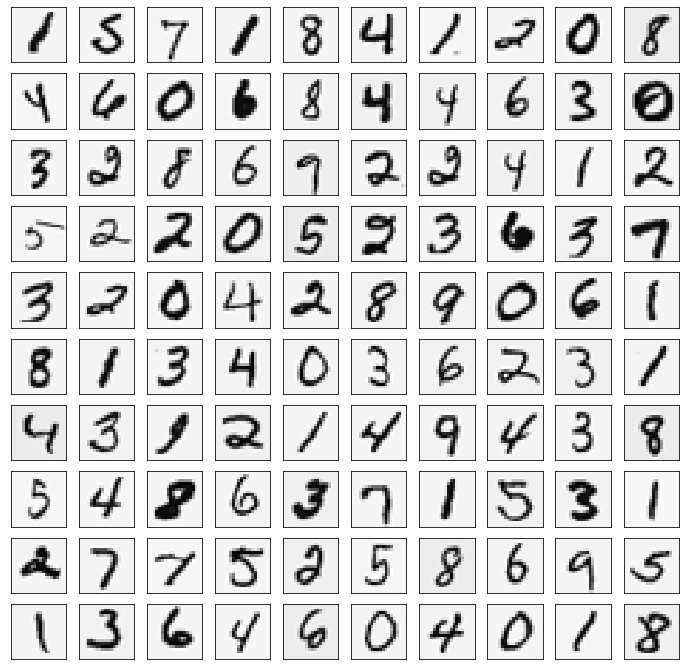

In [7]:
plot_100_image(raw_X)

In [8]:
#对x进行处理，加入偏置项并检查维度
X = np.insert(raw_X,0,values=1,axis=1)
X.shape

(5000, 401)

In [9]:
#对y标签进行one-hot编码
encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(raw_Y)
y.shape

C:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5000, 10)

In [10]:
y#查看编码后的y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [11]:
raw_Y#原来数据集中的y标签，可以和上面对比一下

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]], dtype=uint8)

#### 1.2 对权重参数序列化处理 
主要目的是为了之后的工具库计算参数最优解时传参方便，因为minimize（）对theta要求的维度是（n，）而不是（n，1），返回的结果也是序列化了的。(其实也可以在后面再处理)

In [12]:
#序列化theta1和theta2
def serialize(a,b):
    return np.append(a.flatten(),b.flatten())

In [13]:
theta_ser = serialize(theta1,theta2)
theta_ser.shape #查看序列化后的维度

(10285,)

In [14]:
#解序列化操作，因为前向反向传播用到的都是theta1和theta2
axis1,axis2 = theta1.shape,theta2.shape
def deserialize(theta_ser):
    theta11 = theta_ser[:axis1[0]*axis1[1]].reshape(axis1[0],axis1[1])
    theta22 = theta_ser[axis1[0]*axis1[1]:].reshape(axis2[0],axis2[1])
    return theta11,theta22

In [15]:
#检查一下解序列化后和原来是不是一样
theta1,theta2 = deserialize(theta_ser)
theta1.shape,theta2.shape

((25, 401), (10, 26))

### 2.前向传播 

In [16]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [17]:
def forward_propagate(theta_ser,X):
    theta1,theta2 = deserialize(theta_ser)
    #print(theta1.shape,theta2.shape)
    a1 = X   #（5000，401）
    z2 = a1 @ theta1.T    #（5000，401）@（401，25）=>（5000，25）
    a2 = sigmoid(z2)  
    a2 = np.insert(a2,0,values=1,axis=1)  #加入偏置项后维度变为（5000，26）
    z3 = a2 @ theta2.T   #(5000，26) @（26，10）=>（5000，10）
    h = sigmoid(z3) 
    return a1,z2,a2,z3,h

### 3.代价函数 

#### 3.1不带正则化项的代价函数 ：

In [18]:
def cost(theta_ser,X,y):
    a1,z2,a2,z3,h = forward_propagate(theta_ser,X)
    J = -np.sum(y*np.log(h)+(1-y)*np.log(1-h))/len(X)
    return J

In [19]:
cost(theta_ser,X,y)

0.2876291651613189

#### 3.2 带正则化的代价函数 

In [20]:
def reg_cost(theta_ser,X,y,lmd):
    theta1,theta2 = deserialize(theta_ser)
    sum1 = np.sum(np.power(theta1[:,1:],2))
    sum2 = np.sum(np.power(theta2[:,1:],2))
    reg = (sum1+sum2)*lmd/(2*len(X))
    return reg + cost(theta_ser,X,y)#要加上没有正则化的代价，因为这里仅仅计算了代价函数中带正则化项的那部分

In [21]:
lmd = 1
reg_cost(theta_ser,X,y,lmd)

0.38376985909092365

### 4.反向传播 


#### 4.1 无正则化项的梯度 

In [22]:
#sigmoid函数的梯度
def sigmoid_gradient(z):
    return sigmoid(z)*(1-sigmoid(z))

In [23]:
#反向传播中J对theta1和theta2的误差梯度
def gradient(theta_ser,X,y):
    theta1,theta2 = deserialize(theta_ser)
    #先前向传播获
    a1,z2,a2,z3,h = forward_propagate(theta_ser,X)
    d3 = h - y   #输出节点的误差，可以直接计算输出值与目标值的差值 #d3维度=（5000，10）
    d2 = d3 @ theta2[:,1:]*sigmoid_gradient(z2)    #（5000，10）@ （10，25）=>（5000，25）
    D2 = (d3.T @ a2)/len(X) #（10，5000）@ （5000，25）=>（10，25）
    D1 = (d2.T @ a1)/len(X) #（25，5000）@ （5000，400）=>（25，400）
    return serialize(D1,D2)

#### 4.2 有正则化的梯度 

In [24]:
def reg_gradient(theta_ser,X,y,lmd):
    D = gradient(theta_ser,X,y)
    D1,D2 = deserialize(D)
    theta1,theta2 = deserialize(theta_ser)
    D1[:,1:] = D1[:,1:] + theta1[:,1:]*lmd/len(X) 
    D2[:,1:] = D2[:,1:] + theta2[:,1:]*lmd/len(X) 
    return serialize(D1,D2)

#### 4.3求解

In [25]:
#不带正则化项的
def nn_training(X,y):
    init_theta = np.random.uniform(-0.5,0.5,len(theta_ser))
    res = minimize(fun=cost,
                  x0=init_theta,
                  args = (X,y),
                  method='TNC',
                  jac=gradient,
                  options = {'maxiter':300})#迭代300次
    return res

In [26]:
res = nn_training(X,y) #求解返回的theta是被序列了的

C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
raw_Y = data['y'].reshape(raw_Y.shape[0],)#y的维度变成（5000，）以便和y_pre比较

In [28]:
_,_,_,_,h = forward_propagate(res.x,X)
y_pre = np.argmax(h,axis=1)+1
acc = np.mean(y_pre == raw_Y)
acc

0.9948

In [29]:
#带正则化项的反向传播
def nn_training_reg(X,y):
    init_theta = np.random.uniform(-0.5,0.5,len(theta_ser))
    res = minimize(fun=reg_cost,  #带正则化项的代价函数
                  x0=init_theta,
                  args = (X,y,lmd),#传入lmd的值
                  method='TNC',
                  jac=reg_gradient,  #带正则化项的梯度函数
                  options = {'maxiter':300})#迭代300次
    return res

In [30]:
lmd = 10

res = nn_training_reg(X,y)
raw_Y = data['y'].reshape(raw_Y.shape[0],)
_,_,_,_,h = forward_propagate(res.x,X)
y_pre = np.argmax(h,axis=1)+1
acc = np.mean(y_pre == raw_Y)
acc

0.9394

### 5.隐藏层可视化 

In [31]:
def plot_hidden_layer(theta):
    theta1,theta2 = deserialize(theta)
    hidden_layer = theta1[:,1:]#(25,400),去掉偏置项
    frg,ax = plt.subplots(ncols=5,nrows=5,figsize=(12,12),sharex=True,sharey=True)
    for r in range(5):    #行
        for c in range(5):    #列
            ax[r,c].imshow(hidden_layer[5*r+c,:].reshape(20,20).T,cmap='gray_r')
    plt.xticks([])
    plt.yticks([]) 
    
    plt.show

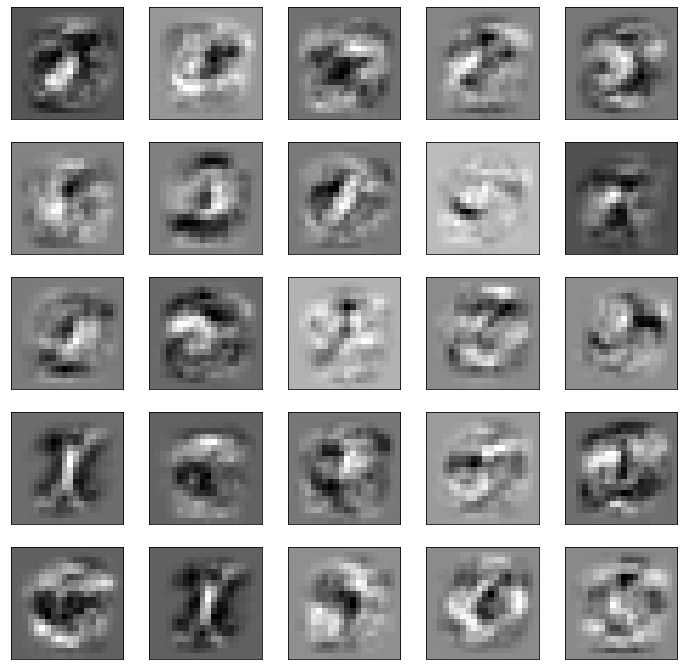

In [32]:
plot_hidden_layer(res.x)